# The Crystal Ball: Time Series Forecasting in Python

This notebook is the exploratory work done for creating the forecasting model.

Notebooks are great for doing exploration and prototyping. Once you've determined the prototype, code should be migrated to python modules. 

# Overview

We have several basic steps for structuring and solving a machine learning problem.

1. Load Data
1. Data Preperation
1. Model Selection
1. Training
1. Evaluation
1. Parameter Tuning
1. Prediction

# Imports

We import modules that will be helpful for us

In [1]:
# standard library
import os

# external
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import fbprophet
import data_science_tools as tools
import sklearn
from sklearn import (
    metrics
)

# local
import the_crystal_ball

In [2]:
# In jupyter notebook, this auto reloads modules when 
# they change which is helpful for our `the_crystal_ball`
# module which we'll want to be developing.

%load_ext autoreload
%autoreload 2

<br>
<br>
<br>
<br>
<br>

# Load Data

Our first step is to load in our data. We also want to visualize and validate our data. Having validation checks as a it's own step will help when we move to production so as new data comes in we can check it against a set of assumptions. 


Visualization and Analysis techniques:

* line plot
* cumulative line plot
* histogram + density plot
* box plot over time
* heat map
* lag scatter plots
* autocorrelation plots


<br>


In [3]:
start = pd.Timestamp('2000-01-01')
stop = pd.Timestamp('2020-11-01')

articles = [
    #'Python_(programming_language)',
    #'Go_(programming_language)',
    #'Guido_van_Rossum',
            
    'Gardening',
    'Soil',
    'Regenerative_agriculture',
    'Vermicompost',
    'Soil_food_web',
    'Food_waste',
    'Hipster_(contemporary_subculture)',
    'Permaculture',    
]

In [4]:
df_input = the_crystal_ball.load_data.get_wikipedia_articles(articles, start, stop)

Download article: Gardening
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Gardening/daily/20000101/20201101
Download article: Soil
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Soil/daily/20000101/20201101
Download article: Regenerative_agriculture
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Regenerative_agriculture/daily/20000101/20201101
Download article: Vermicompost
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Vermicompost/daily/20000101/20201101
Download article: Soil_food_web
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Soil_food_web/daily/20000101/20201101
Download article: Food_waste
Downloading: https://wikimedia.org/api/rest_v1/metrics/pageviews/pe

In [5]:
the_crystal_ball.load_data.validate_input_data(df_input)

Data Passes Validation


Gardening
Soil
Regenerative_agriculture
Vermicompost
Soil_food_web
Food_waste
Hipster_(contemporary_subculture)
Permaculture


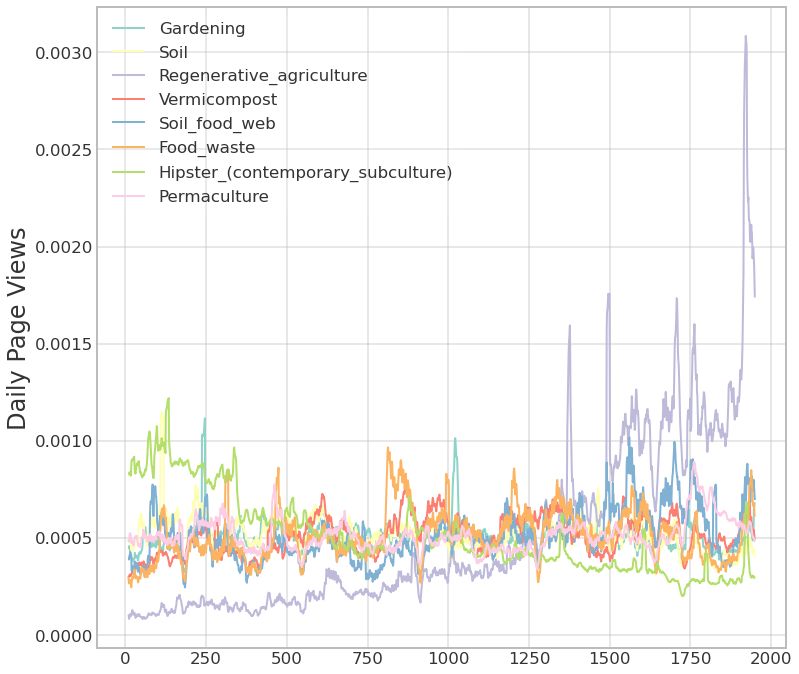

In [13]:
the_crystal_ball.visualization.plot_articles(df_input)

<br>
<br>
<br>
<br>
<br>
<br>


## Data Preperation

Also called feature engineering, data preperation is where we take our input data and prepare it for the machine learning (ML). ML is typically of the form:

```
y = f(X)
```

So in this step we're taking our input data and structuring it so that we have X and y. 


Techniques to use:

* Filtering
* Scaling
* Resampling and Interpolation
* Power Transforms to remove noise (e.g. square root or log transform)
* Moving Average Smoothing

<br>
<br>


In [24]:
df_input.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Gardening,daily,2015-07-01,all-access,all-agents,494
1,en.wikipedia,Gardening,daily,2015-07-02,all-access,all-agents,617
2,en.wikipedia,Gardening,daily,2015-07-03,all-access,all-agents,484
3,en.wikipedia,Gardening,daily,2015-07-04,all-access,all-agents,469
4,en.wikipedia,Gardening,daily,2015-07-05,all-access,all-agents,778


In [25]:
df_features = the_crystal_ball.data_prep.create_features(df_input)
df_features.head()

,ds,y
0,2015-07-01,26
1,2015-07-02,70
2,2015-07-03,25
3,2015-07-04,12
4,2015-07-05,11


In [26]:
filepath = the_crystal_ball.data_prep.store_features(df_features)

writing features to /work/data/features.csv


In [18]:
df_features = the_crystal_ball.data_prep.load_features(filepath)

reading features from /work/data/features.csv


# Model Selection

In [270]:
model = the_crystal_ball.models.create_model(
    'fbprophet',
    daily_seasonality=False,
    yearly_seasonality=True,
)

# Training

Key aspect of machine learning is to train our model. By which we mean we take the model and sample data then adjust the parameters of the model until we minimize some calculated measurement. 


Another key aspect of training is to validate on unseen data. For this we hold out a test set of data and then predict on what that test set would be. 

Two key ways to divide the data into training and test for time series:

* Sliding Window
* Expanding Window

For both of theses it's also important to decide how much overlap you want with previous training.


It's important to visualize your training and test data. Ideally you should be able to see the trends you want the model to learn to see. If your training does not reflect your test set you will have difficulties and may not be able to forecast. 

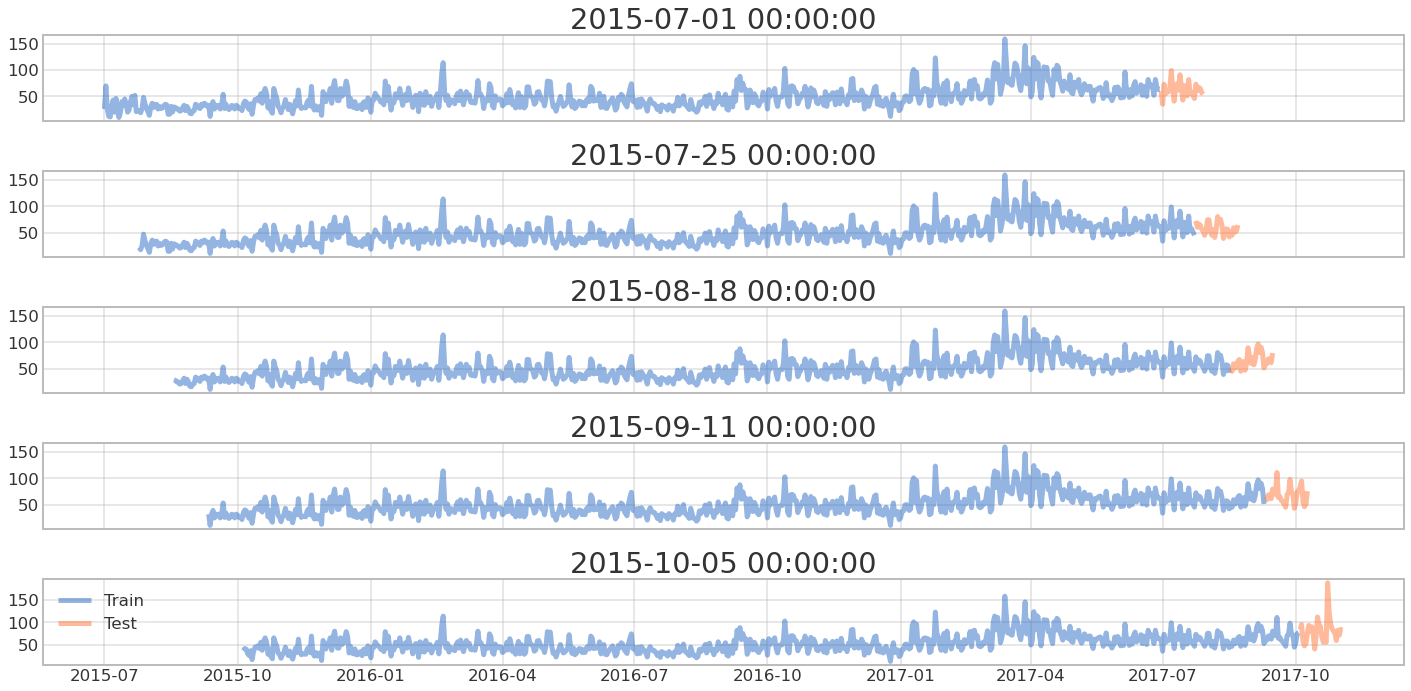

In [271]:
windows = the_crystal_ball.training.compute_sliding_windows_for_data(
    df_features, 
    training_size=365*2, # N days
    test_size=30, # N days
)

the_crystal_ball.visualization.figure_test_train_splits(df_features, windows)    
None

In [278]:
training_results = the_crystal_ball.training.train_model(
    model,
    df_features,
    window=windows[0],
)

evaluating model


# Evaluation

In [280]:
evaluation_params = the_crystal_ball.training.training_results_to_evaulation_params(**training_results)


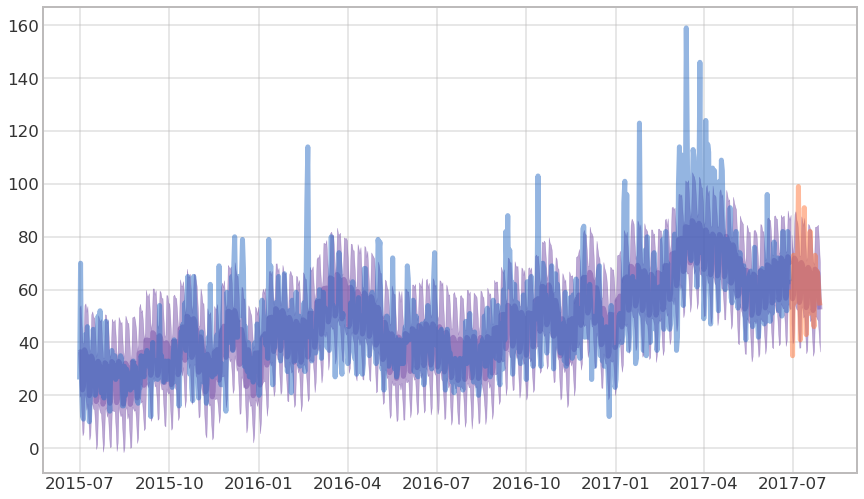

In [281]:
the_crystal_ball.visualization.plot_evaluation_prediction(
    ax=None,
    **evaluation_params,    
)

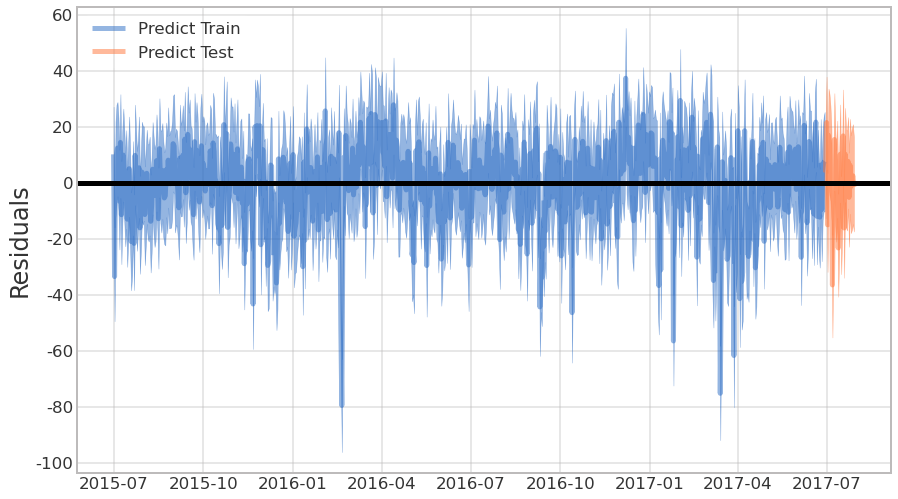

In [282]:
the_crystal_ball.visualization.plot_evaluation_prediction_residual(
    ax=None,
    **evaluation_params,
)

# Parameter Tuning


When you try out different models and parameters for those models. Having functions for the above steps make this much easier. Some tools or platforms which help automate this by setting the parameters.


# Prediction

This is where we take our code and set it up to run the preditions. If we've structured this well, this should be an easy step. Some tools are availble (e.g. Kubeflow, MLRun, OpenFaas, etc) which help with setting up pipeline for prediction and hosting the function.